# Proof of concept: Reconstructing the map state
Natalia Vélez, November 2020

In [1]:
%matplotlib inline

# General
import os,re,glob,sys
from os.path import join as opj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# OHOL-specific modules
sys.path.insert(1, '../3_technology/')
import ohol_objects as obj
import ohol_categories as cat
import ohol_transitions as trans

# Plotting options
sns.set_style('white')
sns.set_context('talk')

## Choose time period for proof of concept

List map seed files:

In [2]:
map_dir = '../../data/publicMapChangeData/bigserver2.onehouronelife.com/'
seed_files = glob.glob(opj(map_dir, '*_mapSeed.txt'))
seed_files.sort()
print('%i map seed resets found' % len(seed_files))
print(*seed_files, sep='\n')

14 map seed resets found
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1573895673time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1574102503time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1576038671time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1578345720time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1578354747time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1579713519time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1580144896time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1581985139time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1583642903time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1584061484time_mapSeed.txt
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1585440511time_mapSeed.txt
../../d

Find seed change times and durations:

In [3]:
def str_extract(pattern, s): return re.search(pattern,s).group(0)
def int_extract(pattern, s): return int(str_extract(pattern, s))

seed_times = [int_extract('[0-9]+(?=time)', f) for f in seed_files]
seed_df = pd.DataFrame(seed_times, columns=['timestamp'])
seed_df['date'] = pd.to_datetime(seed_df['timestamp'],unit='s')
seed_df['dur_hours'] = (seed_df['timestamp'].shift(-1) - seed_df['timestamp'])/60/60
seed_df

,timestamp,date,dur_hours
0,1573895673,2019-11-16 09:14:33,57.452778
1,1574102503,2019-11-18 18:41:43,537.824444
2,1576038671,2019-12-11 04:31:11,640.846944
3,1578345720,2020-01-06 21:22:00,2.507500
4,1578354747,2020-01-06 23:52:27,377.436667
5,1579713519,2020-01-22 17:18:39,119.826944
6,1580144896,2020-01-27 17:08:16,511.178611
7,1581985139,2020-02-18 00:18:59,460.490000
8,1583642903,2020-03-08 04:48:23,116.272500
9,1584061484,2020-03-13 01:04:44,383.063056


[[Text(0, 0, '1'),
  Text(0, 0, '10'),
  Text(0, 0, '100'),
  Text(0, 0, '1000'),
  Text(0, 0, '10000')],
 (0.0, 4.0),
 Text(0.5, 0, 'Duration (hours)')]

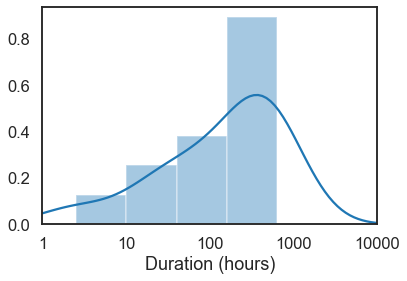

In [4]:
ax = sns.distplot(np.log10(seed_df['dur_hours']))
ax.set(xlim=(0,4), xticklabels=[10**x for x in range(5)], xlabel = 'Duration (hours)')

Pick a seed to study

In [5]:
seed_idx = 10 # This is arbitrary! Eventually we'll iterate over all seeds
t_start = seed_df.loc[seed_idx, 'timestamp']
t_end = seed_df.loc[seed_idx+1, 'timestamp']
print('Studying period between t_start = %i, t_end = %i' % (t_start, t_end))

Studying period between t_start = 1585440511, t_end = 1585512770


## Load map and lifelog data

### Map change data

Find map log files between this time period

In [6]:
def in_interval(t): return (t >= t_start) & (t < t_end) # Helper function

all_log_files = glob.glob(opj(map_dir, '*time_mapLog.txt'))
all_log_files.sort()
print('%i files found' % len(all_log_files))

all_log_times = [int_extract('[0-9]+(?=time)', f) for f in all_log_files]
log_files = [f for f,t in zip(all_log_files, all_log_times) if in_interval(t)]

print('Found %i file within time period' % len(log_files))
print(*log_files, sep='\n')

236 files found
Found 1 file within time period
../../data/publicMapChangeData/bigserver2.onehouronelife.com/1585440511time_mapLog.txt


### Lifelog data

Load lifelogs within this time period:

In [7]:
life_df = pd.read_csv('../2_demographics/outputs/all_lifelogs_compact.tsv', sep='\t', index_col=0)
life_df = life_df[in_interval(life_df['tBirth'])]
life_df = life_df.reset_index(drop=True)

print(life_df.shape)
life_df.head()

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2263, 15)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,4b692426fcab079bbac8984f424c4fd0ee2e7463,2836376,1585512594,2836316,[-1371 -475],1.585513e+09,[-1422 -479],2.13,disconnect,-1371,-475,-1422.0,-479.0,OLIVER,FEUER
1,19ea8b28776b9a8bb60957736e8919b1f0811a15,2836373,1585512568,2836317,[-1034 -883],1.585513e+09,[-1029 -882],2.57,disconnect,-1034,-883,-1029.0,-882.0,MANNY,KAR
2,ee70ce48b140164cb9b2f90ba64ebf491ab5aa39,2836372,1585512553,2836286,[-995 -35],1.585513e+09,[-988 -36],2.81,disconnect,-995,-35,-988.0,-36.0,JOE,PHILPOTT
3,1675a288feb597ee9d1553aa9d3edb6ce075e550,2836371,1585512533,2836320,[-192 -752],1.585513e+09,[-200 -756],3.15,disconnect,-192,-752,-200.0,-756.0,ZEUS,ROHRER
4,1a35d3e127b91e027c4defcb0351145de4e12d7d,2836370,1585512520,2836280,[-1030 -883],1.585513e+09,[-1036 -878],3.37,disconnect,-1030,-883,-1036.0,-878.0,BANE,KAR


Get all eves:

In [8]:
eve_df = life_df[life_df['parent'] < 0]
eve_df.head()

,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
6,dcbdb24bbab66952b72baca3050b2d071d09d38b,2836368,1585512510,-1,[-21250 -20799],1.585513e+09,[-21239 -20760],17.50,hunger,-21250,-20799,-21239.0,-20760.0,EVE,DOBBIE
8,d324804bb94c557cbb3977e45a7a40e36f8a8a52,2836364,1585512383,-1,[-21248 -20814],1.585513e+09,[-20960 -20558],19.65,disconnect,-21248,-20814,-20960.0,-20558.0,EVE,DONES
17,31787cb80d49db779a01fa92f10ea8bc4b29fc61,2836351,1585512144,-1,[-21209 -20751],1.585513e+09,[-21217 -20896],22.42,hunger,-21209,-20751,-21217.0,-20896.0,EVE,BERRY
44,be94184fd94d27e466d4301a7e8bdcbe85fab6fb,2836316,1585511377,-1,[-1153 -616],1.585513e+09,[-1422 -479],36.42,disconnect,-1153,-616,-1422.0,-479.0,EVE,FEUER
45,31787cb80d49db779a01fa92f10ea8bc4b29fc61,2836315,1585511338,-1,[-21171 -20559],1.585512e+09,[-21202 -20234],21.58,hunger,-21171,-20559,-21202.0,-20234.0,EVE,BERRY


## Step 2: Select data for 10-minute demo

Load data within time period:

In [9]:
def load_map(f):
#     # The first line contains a more accurate starting point
#     with open(f, 'r') as handle:
#         header = handle.readline().strip()

#     log_start = str_extract('[0-9.]+', header)
#     log_start = float(log_start)

    # Read the rest of the data
    log_data = pd.read_table(f, sep=' ', skiprows=1,
                             names=['t', 'x', 'y', 'new_state', 'caused_by'])
    log_data['loc'] = log_data.apply(lambda row: '%i,%i' % (row['x'], row['y']), axis=1)
    log_data['item'] = log_data.new_state.str.replace('(^f|v[0-9]+|u[0-9]+)', '')
    log_data['item'] = pd.to_numeric(log_data['item'])
    
    return log_data

log_df = pd.concat([load_map(f) for f in log_files])
print(log_df.shape)
log_df.head()

(1211021, 7)


,t,x,y,new_state,caused_by,loc,item
0,40.50,-26,-350,3053,2832150,"-26,-350",3053
1,43.11,-32,-598,2157,-1,"-32,-598",2157
2,65.30,-203,-750,3051,2832158,"-203,-750",3051
3,67.11,-52,-595,3053,2832152,"-52,-595",3053
4,67.90,-51,-831,0,2832154,"-51,-831",0


Pick a 10-minute interval to start:

In [10]:
log_slice = log_df[log_df['t'] <= 60*10]
log_slice = log_slice[log_slice['x'] < 10000] # Eliminate donkeytown activity

eve_slice = eve_df[eve_df['tBirth'] <= t_start + 60*10]
print(log_slice.shape)
print(eve_slice.shape)

(2031, 7)
(8, 15)


Map activity during this interval, color-coded by family:

[Text(0, 0.5, 'y'), Text(0.5, 0, 'x')]

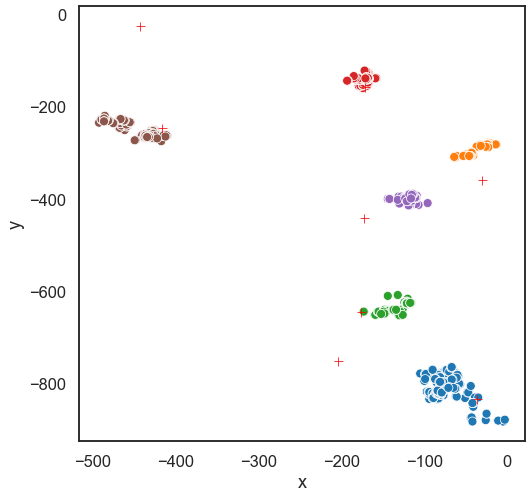

In [11]:
family_df = pd.read_csv('../2_demographics/outputs/family_generations.tsv', sep='\t')
log_family = log_slice.copy()
log_family = log_family.rename(columns={'caused_by': 'avatar'})
log_family = log_family[log_family['avatar'] > 0]
log_family = pd.merge(log_family, family_df)

fig,ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=log_family,x='x', y='y', hue='family', legend=False,ax=ax)
sns.scatterplot(data=eve_slice, x='birthX', y='birthY', marker='+', color='r', ax=ax)
ax.set(xlabel='x', ylabel='y')
#log_slice.head()

How many unique locations and avatars are mentioned within that 10-minute interval?

In [12]:
tstamps = log_slice['t'].to_list()
unique_avatars = np.unique(log_slice[log_slice['caused_by'] > 0]['caused_by'])
unique_locations = np.unique(log_slice['loc'])

print('%i timepoints' % len(tstamps))
print('%i unique avatars' % len(unique_avatars))
print('%i unique locations' % len(unique_locations))

2031 timepoints
83 unique avatars
971 unique locations


## Load game data

Items featured in map log:

In [30]:
unique_items = np.unique(log_slice['item']).tolist()
print(*[obj.obj_name(i) for i in unique_items if i < 5000], sep='\n')

Empty
Wild Gooseberry Bush
Gooseberry
Big Hard Rock
Stone
Sharp Stone
Dug Wild Carrot
Wild Carrot
Lombardy Poplar Tree
Maple Tree
Juniper Tree
Milkweed Debris
Milkweed Debris -Flowering
Milkweed Debris -Fruit
Milkweed Stalk
Thread
Rope
Juniper Tinder
Leaf
Straight Branch
Small Curved Branch
Long Straight Shaft
Small Curved Shaft
Short Shaft
Tied Short Shaft
Stone Hatchet - +toolChopping
Kindling
Bow Drill Bow
Fire Bow Drill - +toolBow_Drill
Ember Shaft
Smoldering Tinder
Fire
Large Fast Fire
Fresh Grave - origGrave fromDeath
Pine Needles
White Pine Tree
Pine Panel
Stakes - +tool
Tule Stumps
Harvested Tule
Reed Bundle
Clay
Adobe
Reed Skirt
Yew Branch
Flint Chip
Sapling Stump
Cut Sapling Skewer
Skewer
Canada Goose Pond
Flint Chips
Snare
Snared Rabbit Hole -hiding
Milkweed Seed
Wheat Seed Head
Harvested Wheat
Wheat Sheaf
Threshed Wheat
Straw
Adobe Oven Base
Wet Clay Bowl
Adobe Oven
Adobe Kiln
Wooden Tongs - empty
Ripe Wheat
Wheat Stumps
Empty Wild Gooseberry Bush
Flat Rock - empty
Basket
T

Load transitions:

In [31]:
trans_files:

SyntaxError: invalid syntax (<ipython-input-31-c714dde5c747>, line 1)

## Reconstruct map

Starting state:

In [13]:
map_keys = ['floor', 'top']
avatar_keys = ['hands', 'clothing']

map_dict = {k1:{k2:''} for k1 in unique_locations for k2 in map_keys}
avatar_keys = {k1:{k2:''} for k1 in unique_avatars for k2 in map_keys}
empty_map = {k:'' for k in dict_keys}

In [14]:
log_slice.tail(50)

,t,x,y,new_state,caused_by,loc,item
7597,593.43,-117,-625,34,2832202,"-117,-625",34
7598,593.67,-412,-265,0,2832190,"-412,-265",0
7599,593.77,-174,-161,292,2832178,"-174,-161",292
7600,593.86,-185,-743,0,2832166,"-185,-743",0
7601,594.01,-83,-815,0,2832155,"-83,-815",0
7602,594.04,-110,-398,30u3,2832175,"-110,-398",30
7603,594.11,-116,-625,0,2832202,"-116,-625",0
7604,594.67,-458,-31,0,2832184,"-458,-31",0
7605,594.79,-73,-788,292,2832156,"-73,-788",292
7606,594.81,-170,-139,135,2832177,"-170,-139",135
